<span style="font-weight: bold; font-size: 18px;">
<p>
<b>Since the text length in the corpus is quite long, even though the language model can handle a maximum input of 8,092 tokens or even longer context, such lengthy contexts can dilute the essential information that the LLM is able to process effectively. When the input text is too long, the model may struggle to focus on the most relevant details, which can negatively impact its performance and the quality of its predictions.</b>
</p>

<p>
To address this challenge, it is beneficial to provide the language model with only the most relevant information from the large corpus, rather than overwhelming it with the entire text. By filtering and condensing the input, we can help the LLM focus on the critical content, thereby enhancing its ability to extract essential information and make more accurate predictions.
</p>

<p>
There are two main approaches to achieve this:<br>
<div style="margin-left: 20px;"><b>• Summarization:</b> Summarization techniques can be used as a form of feature extraction. By generating concise summaries of the original text, we can distill the most important points and reduce the input length, making it easier for the LLM to process and understand the core information.</div><br>
<div style="margin-left: 20px;"><b>• Retrieval-Augmented Generation (RAG):</b> This approach involves retrieving relevant information from the corpus before passing it to the language model. Techniques such as semantic search or keyword-based search (e.g., BM25) can be used to identify and extract the most pertinent sections of text. The retrieved content is then fed into the LLM, ensuring that the model receives focused and contextually relevant information for prediction.</div>
</p>

<p>
By applying either summarization or retrieval-augmented generation, we can significantly improve the efficiency and effectiveness of language models when dealing with large and complex corpora. This targeted approach helps prevent information overload and allows the model to generate more accurate and meaningful outputs.
</span>

In [ ]:
# %%capture --no-stderr
# %pip install langchain langchain-openai langchain_core langchain_community langgraph chromadb python-dotenv pandas numpy

## Summarization + Multi-label classification

#### you need openai-api-key to run the following script

In [2]:
import os
import re
import pandas as pd
import pickle
from typing import Annotated, List,  Optional
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough
from langgraph.graph import MessagesState, START, END, StateGraph
from IPython.display import display, Image
from dotenv import load_dotenv, dotenv_values

In [ ]:
###  input your openai api key into .env file in the path: _dir
_dir="/mnt/d/D-driver/langgraph"
_=load_dotenv(os.path.join(_dir, ".env"))

In [4]:
### Load Dataset for model training and evaluation ###
data_path=os.path.join(os.getcwd(), 'processed_data')
with open(os.path.join(data_path,'data.pkl'), 'rb') as f:
    df = pickle.load(f)

/tmp/ipykernel_1731408/2023378045.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


In [20]:
### here I randomly sample 10 legal documents to demonstrate how to build summarization workflow using LangGraph

sample_df = df[(df['word_count'] >= 500) & (df['word_count'] <= 2000)]\
    .loc[:,['full_text','postures','word_count']]\
    .sample(n=10, random_state=42).reset_index(drop=True)

In [6]:
sample_df.columns

Index(['full_text', 'postures', 'word_count'], dtype='object')

In [7]:
class Doc(TypedDict):
    id: str
    content: str
    word_count: int
    summary_length: int
    explanation_length: int
    summary: Optional[str]
    explanation: Optional[str]

class GraphState(TypedDict):
    documents: List[Doc]

def run_to_doc(df: pd.DataFrame) -> Doc:
    all_data = []
    for i in range(len(df)):
        d = df.iloc[i]
        word_count = int(d['word_count'])
        all_data.append({
            "id": i,
            "content": d['full_text'],
            "word_count": word_count,
            "summary_length": word_count // 3,
            "explanation_length": word_count // 5,
            "posture": d['postures']
        })
    
    return all_data
# Only clustering 100 documents
docs = run_to_doc(sample_df)
print(docs[0])

{'id': 0, 'content': "In a proceeding pursuant to Mental Hygiene Law article 10, Roderick L. appeals from an order of the Supreme Court, Dutchess County (Peter M. Forman, J.), dated January 13, 2017. \u2002The order, upon a finding, made after a jury trial, that Roderick L. suffers from a mental abnormality as defined in Mental Hygiene Law §\u200210.03(i) and a determination, made after a dispositional hearing, that he is a dangerous sex offender requiring civil confinement, in effect, granted the petition and directed that he be committed to a secure treatment facility for care and treatment. ORDERED that the order is affirmed, without costs or disbursements. In June 2000, the appellant was convicted, upon his plea of guilty, of attempted rape in the first degree for a sexual assault he committed on December 23, 1999, against the eight-year-old daughter of his then-girlfriend. \u2002Prior to the release of the appellant from prison, the State of New York commenced this proceeding purs

In [ ]:
_prompt="""
# Instruction

## Context
- **Goal**: You are tasked with summarizing the procedural posture for the legal document in judicial opinion or briefs.
The procedural posture of a case is a summary of how the case arrives before the court.
- **Data**: Your input data is a legal document which describes the procedural history including any prior decisions under appeal.

# Data
<data>
{content}
</data>

# Questions
## Q1. Summarize the input text in {summary_length} words or less.
Write the summary between <summary> </summary> tags.

Tips:
- The summary should contain the relevant information for the procedural posture in as much detail as possible.
- Be concise and clear. Do not add phrases like "This is the summary of the data ..." or "Summarized text: ...".
- Similarly, do not reference the user ('the user asked XYZ') unless it's absolutely relevant.
- Within {summary_length} words, include as much relevant information as possible.
- Do not include any line breaks in the summary.
- Provide your answer in **English** only.

## Q2. Explain how you wrote the summary in {explanation_length} words or less.

## Provide your answers between the tags <summary>your answer to Q1</summary>, <explanation>your answer to Q2</explanation>

# Output


"""

summary_prompt=ChatPromptTemplate.from_template(_prompt)

In [9]:
def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"
    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)
    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""
    return {"summary": summary, "explanation": explanation}

In [10]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0
)

In [11]:
summary_llm_chain = (
    summary_prompt | model | StrOutputParser()
).with_config(run_name="GenerateSummary")

summary_chain = summary_llm_chain | parse_summary

def get_content(state: GraphState):
    docs = state["documents"]
    return [
        {
            "content": doc["content"],
            "summary_length": doc["summary_length"],
            "explanation_length": doc["explanation_length"]
        }
        for doc in docs
    ]

map_step = RunnablePassthrough.assign(
    summaries=get_content
    | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)

def reduce_summaries(combined: dict) -> GraphState:
    summaries = combined["summaries"]
    documents = combined["documents"]
    return {
        "documents": [
            {
                "id": doc["id"],
                "content": doc["content"],
                "posture": doc["posture"],
                "summary": summ_info["summary"],
                "explanation": summ_info["explanation"],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }
# This is the summary node
map_reduce_chain = map_step | reduce_summaries


In [12]:
summary_chain.invoke({"content": docs[0]["content"], 
                      "summary_length":docs[0]["summary_length"], 
                      "explanation_length":docs[0]["explanation_length"]})

{'summary': "Roderick L. appealed an order from the Supreme Court, Dutchess County, which followed a jury trial and dispositional hearing. The jury found Roderick L. to have a mental abnormality under Mental Hygiene Law § 10.03(i), and the court determined he was a dangerous sex offender requiring civil confinement. The order directed his commitment to a secure treatment facility. The appeal argued against the sufficiency of evidence and the admission of certain hearsay evidence. However, the court affirmed the order, finding the evidence legally sufficient and the verdict supported by a fair interpretation of the evidence. The court also upheld the admission of hearsay evidence related to other allegations of sexual assault, finding it reliable and probative. The court permitted the release of grand jury minutes and the admission of a written report from an unavailable expert. The court's finding of Roderick L.'s dangerousness was supported by clear and convincing evidence, justifying

### Graph Execution

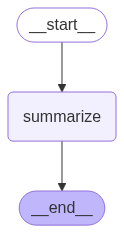

In [13]:
graph=StateGraph(GraphState)
graph.add_node("summarize", map_reduce_chain)
graph.add_edge(START, "summarize")
graph.add_edge("summarize",END)
app=graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
summarization=app.invoke({"documents":docs})

In [17]:
final_result=pd.DataFrame(summarization["documents"])
final_result

,id,content,posture,summary,explanation
0,0,In a proceeding pursuant to Mental Hygiene Law...,On Appeal,"Roderick L. appeals from a Supreme Court, Dutc...","To write the summary, I focused on capturing t..."
1,1,Defendant-appellant Ronald Epps appeals from a...,"Appellate Review, Trial or Guilt Phase Motion ...",Defendant-appellant Ronald Epps appeals from a...,"In writing the summary, I focused on capturing..."
2,2,"Proceeding pursuant to CPLR article 78, in eff...",Review of Administrative Decision,The case involves a CPLR article 78 proceeding...,I wrote the summary by focusing on the procedu...
3,3,"In an action, inter alia, to recover damages f...","Motion to Dismiss, On Appeal",In a legal action involving claims of conversi...,I wrote the summary by focusing on the procedu...
4,4,Appeal from an order of the Family Court of Ch...,On Appeal,This case is an appeal from a Family Court ord...,"I focused on the procedural history, detailing..."
5,5,¶ 1 Travis Padgett appeals trial court orders ...,Appellate Review,Travis Padgett appealed trial court orders den...,"To write the summary, I focused on capturing t..."
6,6,Desima James appeals his 63-month sentence aft...,"Appellate Review, Sentencing or Penalty Phase ...",Desima James appealed his 63-month sentence af...,"To write the summary, I focused on capturing t..."
7,7,It is hereby ORDERED that the judgment so appe...,Appellate Review,The procedural posture of the case involves th...,"In writing the summary, I focused on capturing..."
8,8,Appeal from a judgment of the Supreme Court (N...,"On Appeal, Review of Administrative Decision","Petitioner, a Connecticut resident, had his Ne...",I focused on the key procedural events: the re...
9,9,In an action to recover damages for personal i...,On Appeal,"In a personal injury case, the plaintiff appea...",I focused on summarizing the procedural histor...


In [19]:
row_idx = 0  
row = final_result.iloc[row_idx]

import textwrap
print("="*40)
print("Original Content:\n")
print( textwrap.fill(row['content'], width=100))
print("\n" + "="*40)
print("Summary:\n")
print( textwrap.fill(row['summary'], width=100))
print("\n" + "="*40)
print("Explanation:\n")
print( textwrap.fill(row['explanation'], width=100))
print("="*40)

Original Content:

In a proceeding pursuant to Mental Hygiene Law article 10, Roderick L. appeals from an order of the
Supreme Court, Dutchess County (Peter M. Forman, J.), dated January 13, 2017.  The order, upon a
finding, made after a jury trial, that Roderick L. suffers from a mental abnormality as defined in
Mental Hygiene Law § 10.03(i) and a determination, made after a dispositional hearing, that he is a
dangerous sex offender requiring civil confinement, in effect, granted the petition and directed
that he be committed to a secure treatment facility for care and treatment. ORDERED that the order
is affirmed, without costs or disbursements. In June 2000, the appellant was convicted, upon his
plea of guilty, of attempted rape in the first degree for a sexual assault he committed on December
23, 1999, against the eight-year-old daughter of his then-girlfriend.  Prior to the release of the
appellant from prison, the State of New York commenced this proceeding pursuant to Mental Hyg

## Retrieval Augemented Generation (RAG)

In [58]:
import pandas as pd
import os
import json
from tqdm import tqdm
import operator
from typing import List
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field

from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Send
from IPython.display import display, Image

In [38]:
data_path=os.path.join(os.getcwd(), 'processed_data')
with open(os.path.join(data_path,'data.pkl'), 'rb') as f:
    df = pickle.load(f)

### here I randomly sample 10 legal documents to demonstrate how to build summarization workflow using LangGraph
sample_df = df[(df['word_count'] >= 500) & (df['word_count'] <= 2000)]\
    .loc[:,['document_id', 'full_text','postures']]\
    .sample(n=10, random_state=42).reset_index(drop=True)

/tmp/ipykernel_1731408/3353569349.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


In [39]:
def get_vector_db_retriever(df, embedding_wrapper):
    # Convert DataFrame rows to dictionaries
    RAW_KNOWLEDGE_BASE = [
        Document(
            page_content=row["full_text"],
            metadata={
                "document_id": row["document_id"],
                "postures": row["postures"]
            }
        )
        for row in tqdm(df.to_dict(orient="records"))
    ]
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=512, chunk_overlap=64
    )
    doc_splits = text_splitter.split_documents(RAW_KNOWLEDGE_BASE)

    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embedding_wrapper,
    )
    return vectorstore

In [41]:
emb_model = "text-embedding-ada-002"
embedding_wrapper = OpenAIEmbeddings(model=emb_model)

llm= ChatOpenAI(
    model="gpt-4o",
    temperature=0.0
)

vectorstore=get_vector_db_retriever(sample_df, embedding_wrapper)

100%|██████████| 10/10 [00:00<00:00, 86125.34it/s]


In [45]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

grade_documents_llm = llm.with_structured_output(GradeDocuments)
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question.

- Grade the document as 'yes' if it contains keyword(s) or semantic meaning related to the user question.
- Grade the document as 'no' if it does not relate to user question.

This is not a stringent test; the aim is to filter out irrelevant documents. Provide a binary score of 'yes' or 'no' to indicate whether the retrieved document is relevant to the question."""

grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"


##### rewriting the user question
class RewrittenQueries(BaseModel):
    """Rewritten queries based on the user's original question."""
    rewritten_queries: List[str] = Field(
        description="A list of rewritten versions of the user's query. Each rewritten version is rewritten differently, rephrased and potentially uses synonyms."
    )

rewritten_query_llm = llm.with_structured_output(RewrittenQueries)
rewritten_query_system_prompt = """You are an analyst in charge of taking a user's question as input, and reframing and rewriting it in different ways.\n
Your goal is to change the phrasing of the question, while making sure that the intent and meaning of the question is the same.\n
Return a list of rewritten_queries. The number will be specified by the user."""
rewritten_query_prompt = "Here is the user's question: \n\n {question}. Return {num_rewrites} queries."

question = "what is the procedural posture in the document where the procedural posture describes the procedural history including any prior decisions under appeal."
num_rewrites = 3
rewritten_query_prompt_formatted = rewritten_query_prompt.format(question=question, num_rewrites=num_rewrites)
response=rewritten_query_llm.invoke(
    [SystemMessage(content=rewritten_query_system_prompt)] + [HumanMessage(content=rewritten_query_prompt_formatted)]
)


In [51]:
import textwrap

print("="*40)
print("Original Questions:\n")
print( textwrap.fill(question, width=100))
print()
print("="*40)
print("Rewritten Questions:\n")
for i, q in enumerate(response.rewritten_queries, 1):
    print(f"{i}. {textwrap.fill(q, width=100)}")
    # print( textwrap.fill(q, width=100))

Original Questions:

what is the procedural posture in the document where the procedural posture describes the procedural
history including any prior decisions under appeal.

Rewritten Questions:

1. Can you explain the procedural posture in the document, detailing the procedural history and any
previous decisions that are under appeal?
2. What does the procedural posture in the document reveal about the procedural history and any prior
decisions that are currently being appealed?
3. Could you describe the procedural posture in the document, including the procedural history and any
earlier decisions that are subject to appeal?


In [55]:
##### prompt LLMs to generate a sample answer

class SampleAnswer(BaseModel):
    """Sample answer for an input question."""
    sample_answer: str = Field(
        description="A concise example answer for a question. This shouldn't exceed three sentences in length."
    )

sample_answer_llm = llm.with_structured_output(SampleAnswer)
sample_answer_system_prompt = """You are a novice in charge of taking a user's question as input, and generating a sample answer for it.\n
This sample answer should contain words that would likely be in a real answer, but is not grounded in any factual documents, the way a real answer would be."""
sample_answer_prompt = "Here is the user's question: \n\n {question}."

question = "Can you explain the procedural posture in the document, detailing the procedural history and any \
previous decisions that are under appeal?"
sample_answer_prompt_formatted = sample_answer_prompt.format(question=question)
response=sample_answer_llm.invoke(
    [SystemMessage(content=sample_answer_system_prompt)] + [HumanMessage(content=sample_answer_prompt_formatted)]
)

In [56]:
import textwrap

print("="*40)
print("Questions:\n")
print( textwrap.fill(question, width=100))
print()
print("="*40)
print("Synthetic Answer:\n")
print( textwrap.fill(response.sample_answer, width=100))


Questions:

Can you explain the procedural posture in the document, detailing the procedural history and any
previous decisions that are under appeal?

Synthetic Answer:

The procedural posture involves the case being appealed from a lower court decision where the
plaintiff's claims were dismissed. The procedural history includes the initial filing, motions for
summary judgment, and the trial court's ruling. The current appeal challenges the trial court's
interpretation of the applicable law and seeks a reversal of the dismissal.


In [ ]:
class GraphState(TypedDict):
    question: Annotated[str, operator.add]
    rewritten_queries: List[str]
    documents: Annotated[List[Document], operator.add]
    attempted_generations: int
    document_id: str

def generate_rewritten_queries(state: GraphState):
    """
    Generates rewritten versions of the original user query

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates rewritten_queries key with a list of rewritten queries
    """

    # print("---GENERATING REWRITTEN VERSIONS OF THE USER'S QUERY---")
    question = state["question"]
    num_rewrites = 2
    rewritten_query_prompt_formatted = rewritten_query_prompt.format(question=question, num_rewrites=num_rewrites)
    response = rewritten_query_llm.invoke(
        [SystemMessage(content=rewritten_query_system_prompt)] + [HumanMessage(content=rewritten_query_prompt_formatted)]
    )
    rewritten_queries = response.rewritten_queries

    return {"rewritten_queries": rewritten_queries}

def retrieve_documents(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    # print("---RETRIEVE DOCUMENTS---")
    document_id=state["document_id"]
    question = state["question"]
    retriever_with_filter=vectorstore.as_retriever(
        lambda_mult=1,
        search_kwargs={
            "filter": {"document_id":document_id},
            "k":2

        }
    )
    # Retrieval
    documents = retriever_with_filter.invoke(question)
    return {"documents": documents, "question": question}


def grade_documents(state: GraphState):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    # print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.binary_score
        if grade == "yes":
            # print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            # print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def continue_to_retrieval_nodes(state: GraphState):
    edges_to_create = []
    # Increment attempted_generations
    new_attempted_generations = state["attempted_generations"] + 1
    # Add original question
    edges_to_create.append(Send("retrieve_documents", 
                                {"question": state["question"],
                                 "document_id": state["document_id"], # Include snapshot_id, otherwise it will be missing afterward
                                 "attempted_generations": new_attempted_generations
                                }))
    # Add rewritten queries
    for rewritten_query in state["rewritten_queries"]:
        edges_to_create.append(Send("retrieve_documents", 
                                    {"question": rewritten_query,
                                     "document_id": state["document_id"], # Include snapshot_id, otherwise it will be missing afterward,
                                     "attempted_generations": new_attempted_generations
                                    }))
    return edges_to_create


ATTEMPTED_GENERATION_MAX = 2
def decide_to_rewrite_query(state: GraphState):
    """
    Determines whether to generate an answer, or to terminate execution.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    # print("---ASSESS GRADED DOCUMENTS---")
 
    filtered_documents = state["documents"]
    attempted_generations=state["attempted_generations"]

    if filtered_documents:
        # We have relevant documents, so output these relevant documents
        # print("---DECISION: OUTPUT RELEVANT DOCS---")
        return "output relevant"    # same as END
    elif attempted_generations > ATTEMPTED_GENERATION_MAX:
        # print("---DECISION: EXCEED MAXIMAL ITERATION---")
        return "exceed maximal iteration"
    else:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        # print(
        #     "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---"
        # )
        return "rewrite query"

def absore_node(state: GraphState):
    filtered_documents = state["documents"]
    if filtered_documents:
        return {"filtered_document": filtered_documents}
    return {"filtered_document": []}


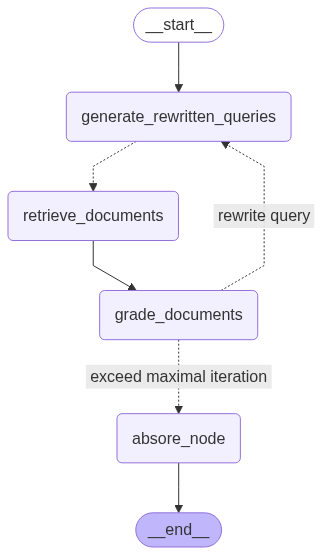

In [72]:
graph_builder = StateGraph(GraphState)

graph_builder.add_node("generate_rewritten_queries", generate_rewritten_queries)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("absore_node", absore_node)
graph_builder.add_edge(START, "generate_rewritten_queries")
graph_builder.add_conditional_edges(
    "generate_rewritten_queries",
    continue_to_retrieval_nodes,
    ["retrieve_documents"]
)
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_rewrite_query,
    {
        "rewrite query": "generate_rewritten_queries",
        "output relevant": "absore_node",
        "exceed maximal iteration": "absore_node",
    })

graph_builder.add_edge("absore_node", END)
graph = graph_builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png(), width=300, height=500))


In [74]:
relevant_text=[]
for idx, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0], leave=True, position=0):
    question = """Can you explain the procedural posture in the document, detailing the procedural history and any 
previous decisions that are under appeal?"""
    document_id=row["document_id"]
    response=graph.invoke({"question": question,
                           "document_id": document_id,
                           "attempted_generations": 0
                           })
    relevant_text.append(response.get("filtered_document",""))

100%|██████████| 10/10 [01:03<00:00,  6.40s/it]


In [75]:
sample_df["relevant_text"]=relevant_text
sample_df


,document_id,full_text,postures,relevant_text
0,I55973ee08ab111e88d669565240b92b2,In a proceeding pursuant to Mental Hygiene Law...,On Appeal,
1,I1722882095ad11e8809390da5fe55bec,Defendant-appellant Ronald Epps appeals from a...,"Appellate Review, Trial or Guilt Phase Motion ...",
2,I09ec1a27edff11e6b92bf4314c15140f,"Proceeding pursuant to CPLR article 78, in eff...",Review of Administrative Decision,
3,If2fec26a8e1411e5a795ac035416da91,"In an action, inter alia, to recover damages f...","Motion to Dismiss, On Appeal",
4,Id199ee2b373411e380938e6f51729d80,Appeal from an order of the Family Court of Ch...,On Appeal,
5,I5f180eb0a72911e8ba29f178bdd7ef1e,¶ 1 Travis Padgett appeals trial court orders ...,Appellate Review,
6,I4abc65509c4411e89b71ea0c471daf33,Desima James appeals his 63-month sentence aft...,"Appellate Review, Sentencing or Penalty Phase ...",
7,I4e847ba0e49711e8aec5b23c3317c9c0,It is hereby ORDERED that the judgment so appe...,Appellate Review,
8,I64b759f02d7611eaa49a848616f1a2d2,Appeal from a judgment of the Supreme Court (N...,"On Appeal, Review of Administrative Decision",
9,I9644a1df096b11e794bae40cad3637b1,In an action to recover damages for personal i...,On Appeal,


In [77]:
print(question)
print()
print(document_id)

Can you explain the procedural posture in the document, detailing the procedural history and any 
previous decisions that are under appeal?

I9644a1df096b11e794bae40cad3637b1


In [78]:
response=graph.invoke({"question": question,
                           "document_id": document_id,
                           "attempted_generations": 0
                           })
response

{'question': 'Can you explain the procedural posture in the document, detailing the procedural history and any \nprevious decisions that are under appeal?Can you explain the procedural posture in the document, detailing the procedural history and any \nprevious decisions that are under appeal?Could you describe the procedural posture outlined in the document, including the procedural history and any prior rulings that are currently being appealed?Would you be able to detail the procedural posture in the document, focusing on the procedural history and any earlier decisions that are subject to appeal?Can you explain the procedural posture in the document, detailing the procedural history and any \nprevious decisions that are under appeal?Can you explain the procedural posture in the document, detailing the procedural history and any \nprevious decisions that are under appeal?Could you describe the procedural posture outlined in the document, including the procedural history and any prio